In [26]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import warnings
warnings.filterwarnings('ignore')

# Financial indicators to forecast
financial_indicators = [
    '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO',
    '10_year_rate', 'share_price', 'unemployment_rate', 'PPI',
    'OECD_CLI_index', 'CSI_index', 'gdp_per_capita'
]

# Recession probability target columns to exclude from features
recession_targets = [
    'recession_probability', '1_month_recession_probability',
    '3_month_recession_probability', '6_month_recession_probability'
]

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


class TimeSeriesDataset(Dataset):
    """Dataset for Informer time series forecasting"""
    def __init__(self, sequences, targets, seq_x_mark, seq_y_mark):
        self.sequences = torch.FloatTensor(sequences)
        self.targets = torch.FloatTensor(targets)
        self.seq_x_mark = torch.FloatTensor(seq_x_mark)
        self.seq_y_mark = torch.FloatTensor(seq_y_mark)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx], self.seq_x_mark[idx], self.seq_y_mark[idx]


class PositionalEmbedding(nn.Module):
    """Positional Embedding for Informer"""
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        pe = torch.zeros(max_len, d_model).float()
        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):
    """Token Embedding converts input features to d_model dimension"""
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model, 
                                    kernel_size=3, padding=1, padding_mode='circular')
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
    
    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class DataEmbedding(nn.Module):
    """Data Embedding = Token Embedding + Positional Embedding"""
    def __init__(self, c_in, d_model, dropout=0.1):
        super(DataEmbedding, self).__init__()
        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        x = self.value_embedding(x) + self.position_embedding(x)
        return self.dropout(x)


class ProbAttention(nn.Module):
    """ProbSparse Self-Attention - Key innovation of Informer"""
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1):
        super(ProbAttention, self).__init__()
        self.factor = factor
        self.scale = scale
        self.mask_flag = mask_flag
        self.dropout = nn.Dropout(attention_dropout)
        
    def _prob_QK(self, Q, K, sample_k, n_top):
        B, H, L_K, E = K.shape
        _, _, L_Q, _ = Q.shape
        
        # Calculate the sampled Q_K
        K_expand = K.unsqueeze(-3).expand(B, H, L_Q, L_K, E)
        index_sample = torch.randint(L_K, (L_Q, sample_k))
        K_sample = K_expand[:, :, torch.arange(L_Q).unsqueeze(1), index_sample, :]
        Q_K_sample = torch.matmul(Q.unsqueeze(-2), K_sample.transpose(-2, -1)).squeeze(-2)
        
        # Find the Top_k query with sparsity measurement
        M = Q_K_sample.max(-1)[0] - torch.div(Q_K_sample.sum(-1), L_K)
        M_top = M.topk(n_top, sorted=False)[1]
        
        # Use the reduced Q to calculate Q_K
        Q_reduce = Q[torch.arange(B)[:, None, None],
                     torch.arange(H)[None, :, None],
                     M_top, :]
        Q_K = torch.matmul(Q_reduce, K.transpose(-2, -1))
        
        return Q_K, M_top
    
    def _get_initial_context(self, V, L_Q):
        B, H, L_V, D = V.shape
        if not self.mask_flag:
            V_sum = V.mean(dim=-2)
            contex = V_sum.unsqueeze(-2).expand(B, H, L_Q, V_sum.shape[-1]).clone()
        else:
            assert(L_Q == L_V)
            contex = V.cumsum(dim=-2)
        return contex
    
    def _update_context(self, context_in, V, scores, index, L_Q):
        B, H, L_V, D = V.shape
        
        attn = torch.softmax(scores, dim=-1)
        context_in[torch.arange(B)[:, None, None],
                   torch.arange(H)[None, :, None],
                   index, :] = torch.matmul(attn, V).type_as(context_in)
        
        return context_in
    
    def forward(self, queries, keys, values):
        B, L_Q, H, D = queries.shape
        _, L_K, _, _ = keys.shape
        
        queries = queries.transpose(2, 1)
        keys = keys.transpose(2, 1)
        values = values.transpose(2, 1)
        
        U_part = self.factor * np.ceil(np.log(L_K)).astype('int').item()
        u = self.factor * np.ceil(np.log(L_Q)).astype('int').item()
        
        U_part = U_part if U_part < L_K else L_K
        u = u if u < L_Q else L_Q
        
        scores_top, index = self._prob_QK(queries, keys, sample_k=U_part, n_top=u)
        
        scale = self.scale or 1./math.sqrt(D)
        if scale is not None:
            scores_top = scores_top * scale
        
        context = self._get_initial_context(values, L_Q)
        context = self._update_context(context, values, scores_top, index, L_Q)
        
        return context.transpose(2, 1).contiguous()


class AttentionLayer(nn.Module):
    """Attention Layer wrapper"""
    def __init__(self, attention, d_model, n_heads, d_keys=None, d_values=None):
        super(AttentionLayer, self).__init__()
        
        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)
        
        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads
        
    def forward(self, queries, keys, values):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads
        
        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)
        
        out = self.inner_attention(queries, keys, values)
        out = out.view(B, L, -1)
        
        return self.out_projection(out)


class EncoderLayer(nn.Module):
    """Informer Encoder Layer"""
    def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu
        
    def forward(self, x):
        new_x = self.attention(x, x, x)
        x = x + self.dropout(new_x)
        
        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        
        return self.norm2(x + y)


class Encoder(nn.Module):
    """Informer Encoder"""
    def __init__(self, attn_layers, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.norm = norm_layer
        
    def forward(self, x):
        for attn_layer in self.attn_layers:
            x = attn_layer(x)
        
        if self.norm is not None:
            x = self.norm(x)
        
        return x


class DecoderLayer(nn.Module):
    """Informer Decoder Layer"""
    def __init__(self, self_attention, cross_attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(DecoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu
        
    def forward(self, x, cross):
        x = x + self.dropout(self.self_attention(x, x, x))
        x = self.norm1(x)
        
        x = x + self.dropout(self.cross_attention(x, cross, cross))
        
        y = x = self.norm2(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        
        return self.norm3(x + y)


class Decoder(nn.Module):
    """Informer Decoder"""
    def __init__(self, layers, norm_layer=None):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer
        
    def forward(self, x, cross):
        for layer in self.layers:
            x = layer(x, cross)
        
        if self.norm is not None:
            x = self.norm(x)
        
        return x


class Informer(nn.Module):
    """
    Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting
    Paper: https://arxiv.org/abs/2012.07436
    """
    def __init__(self, enc_in, dec_in, c_out, seq_len, label_len, out_len, 
                 factor=5, d_model=512, n_heads=8, e_layers=3, d_layers=2, d_ff=2048, 
                 dropout=0.1, activation='gelu'):
        super(Informer, self).__init__()
        self.pred_len = out_len
        self.label_len = label_len
        
        # Embedding
        self.enc_embedding = DataEmbedding(enc_in, d_model, dropout)
        self.dec_embedding = DataEmbedding(dec_in, d_model, dropout)
        
        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        ProbAttention(False, factor, attention_dropout=dropout), 
                        d_model, n_heads
                    ),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation
                ) for l in range(e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model)
        )
        
        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AttentionLayer(
                        ProbAttention(True, factor, attention_dropout=dropout), 
                        d_model, n_heads
                    ),
                    AttentionLayer(
                        ProbAttention(False, factor, attention_dropout=dropout), 
                        d_model, n_heads
                    ),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation
                ) for l in range(d_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model)
        )
        
        # Output projection
        self.projection = nn.Linear(d_model, c_out, bias=True)
        
    def forward(self, x_enc, x_dec):
        enc_out = self.enc_embedding(x_enc)
        enc_out = self.encoder(enc_out)
        
        dec_out = self.dec_embedding(x_dec)
        dec_out = self.decoder(dec_out, enc_out)
        dec_out = self.projection(dec_out)
        
        return dec_out[:, -self.pred_len:, :]


def prepare_exogenous_features(train_df, test_df, target_indicator):
    """Prepare exogenous features for Informer"""
    print(f"\nPreparing exogenous features for {target_indicator}...")
    
    features_to_exclude = ['date'] + recession_targets + [target_indicator]
    available_features = [c for c in train_df.columns if c not in features_to_exclude]
    
    print(f"Available exogenous features: {len(available_features)}")
    print(f"Features: {available_features[:10]}..." if len(available_features) > 10 else f"Features: {available_features}")
    
    common_features = [f for f in available_features if f in test_df.columns]
    
    if len(common_features) != len(available_features):
        missing_in_test = set(available_features) - set(common_features)
        print(f"Warning: {len(missing_in_test)} features missing in test data")
    
    return common_features


def clean_data_for_informer(train_df, test_df, target_indicator, exog_features):
    """Clean and prepare data for Informer with robust handling of invalid values"""
    print(f"Cleaning exogenous features for {target_indicator}...")
    
    all_features = [target_indicator] + exog_features
    
    # Data should already have target NaNs dropped, just select columns
    train_data = train_df[all_features].copy()
    test_data = test_df[all_features].copy()
    
    # Check for NaNs in target BEFORE cleaning
    print(f"  NaNs in target before cleaning - Train: {train_data[target_indicator].isna().sum()}, Test: {test_data[target_indicator].isna().sum()}")
    
    # Handle inf values and NaNs in ALL columns
    train_data = train_data.replace([np.inf, -np.inf], np.nan)
    test_data = test_data.replace([np.inf, -np.inf], np.nan)
    
    # Fill NaNs in EXOGENOUS features (not target, it's already clean)
    # This mirrors Prophet's approach: fill features, keep target as-is
    for feature in exog_features:
        if feature in train_data.columns:
            # Forward fill, backward fill, then use median (same as Prophet)
            train_data[feature] = train_data[feature].fillna(method='ffill').fillna(method='bfill')
            test_data[feature] = test_data[feature].fillna(method='ffill').fillna(method='bfill')
            
            train_median = train_data[feature].median()
            if pd.isna(train_median):
                train_median = 0
            train_data[feature] = train_data[feature].fillna(train_median)
            test_data[feature] = test_data[feature].fillna(train_median)
            
            # Final fallback
            train_data[feature] = train_data[feature].fillna(0)
            test_data[feature] = test_data[feature].fillna(0)
    
    # CRITICAL: Check for any remaining NaNs or Infs
    train_has_nan = train_data.isna().any().any()
    train_has_inf = np.isinf(train_data.select_dtypes(include=[np.number])).any().any()
    test_has_nan = test_data.isna().any().any()
    test_has_inf = np.isinf(test_data.select_dtypes(include=[np.number])).any().any()
    
    if train_has_nan or train_has_inf:
        print(f"  WARNING: Train data still has invalid values!")
        print(f"    NaNs: {train_data.isna().sum().sum()}")
        print(f"    Infs: {np.isinf(train_data.select_dtypes(include=[np.number])).sum().sum()}")
        # Force fill all remaining
        train_data = train_data.fillna(0).replace([np.inf, -np.inf], 0)
    
    if test_has_nan or test_has_inf:
        print(f"  WARNING: Test data still has invalid values!")
        test_data = test_data.fillna(0).replace([np.inf, -np.inf], 0)
    
    print(f"  NaNs in target after cleaning - Train: {train_data[target_indicator].isna().sum()}, Test: {test_data[target_indicator].isna().sum()}")
    
    varying_features = []
    for feature in exog_features:
        if feature in train_data.columns and train_data[feature].nunique() > 1:
            varying_features.append(feature)
        else:
            train_data = train_data.drop(columns=[feature], errors='ignore')
            test_data = test_data.drop(columns=[feature], errors='ignore')
    
    print(f"  Train shape: {train_data.shape}, Test shape: {test_data.shape}")
    print(f"  Features with variation: {len(varying_features)}")
    
    return train_data, test_data, varying_features


def create_informer_sequences(data, seq_len, label_len, pred_len):
    """Create sequences for Informer (encoder input, decoder input, target)"""
    sequences_x = []
    sequences_y = []
    sequences_x_mark = []
    sequences_y_mark = []
    
    for i in range(len(data) - seq_len - pred_len + 1):
        # Encoder input
        seq_x = data[i:i + seq_len]
        sequences_x.append(seq_x)
        
        # Decoder input: last label_len of encoder + pred_len zeros
        seq_y = np.concatenate([
            data[i + seq_len - label_len:i + seq_len],
            np.zeros((pred_len, data.shape[1]))
        ], axis=0)
        sequences_y.append(seq_y)
        
        # Time marks (simplified as position indices)
        x_mark = np.arange(seq_len).reshape(-1, 1)
        y_mark = np.arange(label_len + pred_len).reshape(-1, 1)
        sequences_x_mark.append(x_mark)
        sequences_y_mark.append(y_mark)
    
    return (np.array(sequences_x), np.array(sequences_y), 
            np.array(sequences_x_mark), np.array(sequences_y_mark))


def train_informer_model(model, train_loader, val_loader, epochs=50, lr=0.0001, patience=10):
    """Train the Informer model with robust NaN handling"""
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        batch_count = 0
        
        for x_enc, y_true, x_mark, y_mark in train_loader:
            # Check for NaN/Inf in input data
            if torch.isnan(x_enc).any() or torch.isinf(x_enc).any():
                print(f"  WARNING: NaN/Inf detected in input batch, skipping...")
                continue
            
            x_enc, y_true = x_enc.to(device), y_true.to(device)
            
            # Decoder input (set target values to 0 for prediction)
            y_dec = torch.zeros_like(y_true).to(device)
            y_dec[:, :model.label_len, :] = x_enc[:, -model.label_len:, :]
            
            optimizer.zero_grad()
            
            try:
                outputs = model(x_enc, y_dec)
                
                # Check for NaN in outputs
                if torch.isnan(outputs).any() or torch.isinf(outputs).any():
                    print(f"  WARNING: NaN/Inf in model outputs at epoch {epoch+1}, skipping batch")
                    continue
                
                # Loss only on prediction part
                loss = criterion(outputs, y_true[:, -model.pred_len:, :1])
                
                # Check for NaN loss
                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"  WARNING: NaN/Inf loss at epoch {epoch+1}, skipping batch")
                    continue
                
                loss.backward()
                
                # Gradient clipping with check
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                # Check for NaN in gradients
                has_nan_grad = False
                for param in model.parameters():
                    if param.grad is not None:
                        if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                            has_nan_grad = True
                            break
                
                if has_nan_grad:
                    print(f"  WARNING: NaN/Inf in gradients at epoch {epoch+1}, skipping batch")
                    optimizer.zero_grad()
                    continue
                
                optimizer.step()
                
                train_loss += loss.item()
                batch_count += 1
                
            except RuntimeError as e:
                print(f"  ERROR in training at epoch {epoch+1}: {e}")
                continue
        
        if batch_count == 0:
            print(f"  ERROR: No valid batches in epoch {epoch+1}")
            break
        
        train_loss /= batch_count
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        val_batch_count = 0
        
        with torch.no_grad():
            for x_enc, y_true, x_mark, y_mark in val_loader:
                if torch.isnan(x_enc).any() or torch.isinf(x_enc).any():
                    continue
                    
                x_enc, y_true = x_enc.to(device), y_true.to(device)
                
                y_dec = torch.zeros_like(y_true).to(device)
                y_dec[:, :model.label_len, :] = x_enc[:, -model.label_len:, :]
                
                try:
                    outputs = model(x_enc, y_dec)
                    
                    if torch.isnan(outputs).any() or torch.isinf(outputs).any():
                        continue
                    
                    loss = criterion(outputs, y_true[:, -model.pred_len:, :1])
                    
                    if torch.isnan(loss) or torch.isinf(loss):
                        continue
                    
                    val_loss += loss.item()
                    val_batch_count += 1
                    
                except RuntimeError:
                    continue
        
        if val_batch_count == 0:
            print(f"  ERROR: No valid validation batches in epoch {epoch+1}")
            break
        
        val_loss /= val_batch_count
        val_losses.append(val_loss)
        
        scheduler.step(val_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    if len(train_losses) == 0:
        print("ERROR: Training failed completely - no valid losses recorded")
        return model, [float('inf')], [float('inf')]
    
    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses


def auto_adjust_informer_params(train_len, test_len):
    """
    Automatically adjust Informer parameters based on data size
    
    Returns optimal seq_len, label_len, pred_len
    """
    print(f"\nAuto-adjusting Informer parameters...")
    print(f"  Train length: {train_len}, Test length: {test_len}")
    
    # For test predictions, we need: test_len > seq_len
    # Rule: seq_len should be ~40-60% of train length, but not exceed test_len
    seq_len = min(int(train_len * 0.5), test_len - 10, 96)
    
    # label_len should be ~50% of seq_len
    label_len = int(seq_len * 0.5)
    
    # pred_len should be reasonable for financial forecasting
    pred_len = min(24, int(test_len * 0.3), label_len)
    
    # Ensure minimums
    seq_len = max(seq_len, 24)
    label_len = max(label_len, 12)
    pred_len = max(pred_len, 1)
    
    print(f"  Adjusted parameters:")
    print(f"    seq_len: {seq_len}")
    print(f"    label_len: {label_len}")
    print(f"    pred_len: {pred_len}")
    
    return seq_len, label_len, pred_len


def forecast_indicator_with_informer(train_df, test_df, indicator, 
                                     seq_len=None, label_len=None, pred_len=None,
                                     d_model=512, n_heads=8, e_layers=2, d_layers=1,
                                     d_ff=2048, factor=5, epochs=50, batch_size=32, lr=0.0001,
                                     auto_adjust=True, val_split=0.2):
    """
    Forecast indicator using Informer model
    
    Process:
    1. Split train_df into train_part and val_part
    2. Train model on train_part, validate on val_part
    3. Retrain on entire train_df
    4. Predict on test_df
    """
    print(f"\n{'='*60}\nFORECASTING WITH INFORMER: {indicator}\n{'='*60}")
    
    if indicator not in train_df.columns or indicator not in test_df.columns:
        print(f"ERROR: {indicator} not in datasets")
        return None
    
    # Check for missing data
    print(f"Data availability check:")
    print(f"  Original train_df length: {len(train_df)}")
    print(f"  Missing values in train: {train_df[indicator].isna().sum()} ({train_df[indicator].isna().sum()/len(train_df)*100:.1f}%)")
    print(f"  Original test_df length: {len(test_df)}")
    print(f"  Missing values in test: {test_df[indicator].isna().sum()} ({test_df[indicator].isna().sum()/len(test_df)*100:.1f}%)")
    
    train_series = train_df[indicator].dropna()
    test_series = test_df[indicator].dropna()
    print(f"After removing NaNs - Train: {len(train_series)}, Test: {len(test_series)}")
    
    # Show date range
    train_dates_all = train_df.loc[train_series.index, 'date']
    test_dates_all = test_df.loc[test_series.index, 'date']
    if len(train_dates_all) > 0 and len(test_dates_all) > 0:
        print(f"Date ranges:")
        print(f"  Train: {pd.to_datetime(train_dates_all.iloc[0]).strftime('%Y-%m-%d')} to {pd.to_datetime(train_dates_all.iloc[-1]).strftime('%Y-%m-%d')}")
        print(f"  Test: {pd.to_datetime(test_dates_all.iloc[0]).strftime('%Y-%m-%d')} to {pd.to_datetime(test_dates_all.iloc[-1]).strftime('%Y-%m-%d')}")
    
    # Auto-adjust parameters if enabled and not explicitly set
    if auto_adjust and (seq_len is None or label_len is None or pred_len is None):
        seq_len, label_len, pred_len = auto_adjust_informer_params(len(train_series), len(test_series))
    else:
        # Use defaults if not provided
        seq_len = seq_len or 96
        label_len = label_len or 48
        pred_len = pred_len or 24
    
    if len(train_series) < seq_len + pred_len + 20:
        print(f"ERROR: Insufficient training data for {indicator}")
        print(f"  Need at least {seq_len + pred_len + 20}, have {len(train_series)}")
        print(f"  Try reducing seq_len or use auto_adjust=True")
        return None
    
    if len(test_series) <= seq_len:
        print(f"ERROR: Test set too short for prediction")
        print(f"  Need at least {seq_len + 1}, have {len(test_series)}")
        print(f"  Try reducing seq_len or use auto_adjust=True")
        return None
    
    # ==================== PHASE 1: PREPARE DATA ====================
    try:
        exog_features = prepare_exogenous_features(train_df, test_df, indicator)
        train_data, test_data, varying_features = clean_data_for_informer(
            train_df, test_df, indicator, exog_features
        )
        
        # *** CRITICAL FIX: Extract test dates HERE ***
        test_valid_indices = test_df[indicator].dropna().index
        test_dates = test_df.loc[test_valid_indices, 'date'].values
        
        if len(varying_features) == 0:
            print(f"WARNING: No exogenous features available for {indicator}")
            varying_features = []
        
        print(f"Using {len(varying_features)} exogenous features")
        
    except Exception as e:
        print(f"ERROR preparing features: {e}")
        return None
    
    # ==================== PHASE 2: SPLIT TRAIN INTO TRAIN + VAL ====================
    try:
        feature_cols = [indicator] + varying_features
        train_array = train_data[feature_cols].values
        test_array = test_data[feature_cols].values
        
        # Split train data for validation
        val_size = max(int(val_split * len(train_array)), seq_len + pred_len + 10)
        val_size = min(val_size, int(0.3 * len(train_array)))  # Cap at 30%
        
        train_part = train_array[:-val_size]
        val_part = train_array[-val_size:]
        
        print(f"\nData split:")
        print(f"  Train part: {train_part.shape[0]} samples")
        print(f"  Val part: {val_part.shape[0]} samples")
        print(f"  Test: {test_array.shape[0]} samples")
        
        # Scale data - fit on train_part only
        scaler = StandardScaler()
        train_part_scaled = scaler.fit_transform(train_part)
        val_part_scaled = scaler.transform(val_part)
        
        # CRITICAL: Check for NaNs or Infs after scaling
        if np.isnan(train_part_scaled).any() or np.isinf(train_part_scaled).any():
            print("  ERROR: Scaled training data contains NaN or Inf!")
            print(f"    NaNs: {np.isnan(train_part_scaled).sum()}")
            print(f"    Infs: {np.isinf(train_part_scaled).sum()}")
            print("  Attempting to fix...")
            train_part_scaled = np.nan_to_num(train_part_scaled, nan=0.0, posinf=0.0, neginf=0.0)
            val_part_scaled = np.nan_to_num(val_part_scaled, nan=0.0, posinf=0.0, neginf=0.0)
        
        # Check scaler statistics
        print(f"  Scaler mean range: [{scaler.mean_.min():.4f}, {scaler.mean_.max():.4f}]")
        print(f"  Scaler scale range: [{scaler.scale_.min():.4f}, {scaler.scale_.max():.4f}]")
        
        # Check if any scale is too small (would cause explosion)
        if (scaler.scale_ < 1e-6).any():
            print("  WARNING: Some features have very small variance, may cause instability")
            # Replace small scales
            scaler.scale_ = np.where(scaler.scale_ < 1e-6, 1.0, scaler.scale_)
        
        # Create sequences for training
        train_x, train_y, train_x_mark, train_y_mark = create_informer_sequences(
            train_part_scaled, seq_len, label_len, pred_len
        )
        
        # Create sequences for validation
        val_x, val_y, val_x_mark, val_y_mark = create_informer_sequences(
            val_part_scaled, seq_len, label_len, pred_len
        )
        
        print(f"Sequence shapes:")
        print(f"  Train sequences: {train_x.shape}")
        print(f"  Val sequences: {val_x.shape}")
        
        train_dataset = TimeSeriesDataset(train_x, train_y, train_x_mark, train_y_mark)
        val_dataset = TimeSeriesDataset(val_x, val_y, val_x_mark, val_y_mark)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
    except Exception as e:
        print(f"ERROR preparing sequences: {e}")
        import traceback
        traceback.print_exc()
        return None
    
    # ==================== PHASE 3: TRAIN MODEL ON TRAIN_PART ====================
    try:
        enc_in = train_array.shape[1]
        dec_in = train_array.shape[1]
        c_out = 1  # Predicting only the target
        
        model = Informer(
            enc_in=enc_in,
            dec_in=dec_in,
            c_out=c_out,
            seq_len=seq_len,
            label_len=label_len,
            out_len=pred_len,
            factor=factor,
            d_model=d_model,
            n_heads=n_heads,
            e_layers=e_layers,
            d_layers=d_layers,
            d_ff=d_ff,
            dropout=0.1,
            activation='gelu'
        ).to(device)
        
        print(f"\nInformer Model Architecture:")
        print(f"  Encoder input dim: {enc_in}")
        print(f"  Decoder input dim: {dec_in}")
        print(f"  Output dim: {c_out}")
        print(f"  Sequence length: {seq_len}")
        print(f"  Label length: {label_len}")
        print(f"  Prediction length: {pred_len}")
        print(f"  D_model: {d_model}")
        print(f"  Num heads: {n_heads}")
        print(f"  Encoder layers: {e_layers}")
        print(f"  Decoder layers: {d_layers}")
        print(f"  Total parameters: {sum(p.numel() for p in model.parameters())}")
        
        print(f"\nPhase 1: Training on train_part, validating on val_part...")
        model, train_losses, val_losses = train_informer_model(
            model, train_loader, val_loader, 
            epochs=epochs, lr=lr, patience=15
        )
        
        print(f"Phase 1 complete. Best validation loss: {min(val_losses):.6f}")
        
    except Exception as e:
        print(f"ERROR training model: {e}")
        import traceback
        traceback.print_exc()
        return None
    
    # ==================== PHASE 4: RETRAIN ON FULL TRAIN_DF ====================
    try:
        print(f"\nPhase 2: Retraining on ENTIRE train_df for final predictions...")
        
        # Refit scaler on entire training data
        scaler_final = StandardScaler()
        train_full_scaled = scaler_final.fit_transform(train_array)
        test_scaled = scaler_final.transform(test_array)
        
        # Create sequences for full training
        train_full_x, train_full_y, train_full_x_mark, train_full_y_mark = create_informer_sequences(
            train_full_scaled, seq_len, label_len, pred_len
        )
        
        print(f"Full training sequences: {train_full_x.shape}")
        
        # Create dataset and loader for full training
        train_full_dataset = TimeSeriesDataset(train_full_x, train_full_y, train_full_x_mark, train_full_y_mark)
        train_full_loader = DataLoader(train_full_dataset, batch_size=batch_size, shuffle=True)
        
        # Create a fresh model with same architecture
        model_final = Informer(
            enc_in=enc_in,
            dec_in=dec_in,
            c_out=c_out,
            seq_len=seq_len,
            label_len=label_len,
            out_len=pred_len,
            factor=factor,
            d_model=d_model,
            n_heads=n_heads,
            e_layers=e_layers,
            d_layers=d_layers,
            d_ff=d_ff,
            dropout=0.1,
            activation='gelu'
        ).to(device)
        
        # Train on full dataset (use fewer epochs since we know good hyperparams)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model_final.parameters(), lr=lr)
        
        final_epochs = max(10, epochs // 3)  # Use 1/3 of original epochs
        print(f"Training for {final_epochs} epochs on full dataset...")
        
        final_train_losses = []
        for epoch in range(final_epochs):
            model_final.train()
            train_loss = 0
            for x_enc, y_true, x_mark, y_mark in train_full_loader:
                x_enc, y_true = x_enc.to(device), y_true.to(device)
                
                y_dec = torch.zeros_like(y_true).to(device)
                y_dec[:, :model_final.label_len, :] = x_enc[:, -model_final.label_len:, :]
                
                optimizer.zero_grad()
                outputs = model_final(x_enc, y_dec)
                loss = criterion(outputs, y_true[:, -model_final.pred_len:, :1])
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model_final.parameters(), max_norm=1.0)
                optimizer.step()
                
                train_loss += loss.item()
            
            train_loss /= len(train_full_loader)
            final_train_losses.append(train_loss)
            
            if (epoch + 1) % 5 == 0 or epoch == final_epochs - 1:
                print(f"Epoch [{epoch+1}/{final_epochs}], Train Loss: {train_loss:.6f}")
        
        print(f"Phase 2 complete. Final training loss: {final_train_losses[-1]:.6f}")
        
    except Exception as e:
        print(f"ERROR retraining model: {e}")
        import traceback
        traceback.print_exc()
        return None
    
    # ==================== PHASE 5: MAKE PREDICTIONS ON TEST_DF ====================
    try:
        print(f"\nPhase 3: Making predictions on test_df...")
        model_final.eval()
        predictions = []
        
        print(f"  Test data length: {len(test_scaled)}")
        print(f"  Sequence length needed: {seq_len}")
        
        # Use the last seq_len of training data + rolling through test data
        # Concatenate last part of training with test for seamless prediction
        combined_data = np.vstack([train_full_scaled[-seq_len:], test_scaled])
        print(f"  Combined data length: {len(combined_data)}")
        
        # Now we can predict for ALL test samples
        num_test_predictions = len(test_scaled)
        print(f"  Will generate {num_test_predictions} predictions (full test set)")
        
        # Rolling predictions through the entire test set
        for i in range(num_test_predictions):
            # Take seq_len from combined data
            # i=0: uses last seq_len from train
            # i>0: uses mix of train/test or just test
            x_enc = combined_data[i:i + seq_len]
            x_enc_tensor = torch.FloatTensor(x_enc).unsqueeze(0).to(device)
            
            # Prepare decoder input
            y_dec = np.zeros((label_len + pred_len, train_array.shape[1]))
            y_dec[:label_len] = combined_data[i + seq_len - label_len:i + seq_len]
            y_dec_tensor = torch.FloatTensor(y_dec).unsqueeze(0).to(device)
            
            with torch.no_grad():
                pred = model_final(x_enc_tensor, y_dec_tensor)
                # Take only the first prediction (one-step ahead)
                predictions.append(pred.cpu().numpy()[0, 0, 0])
        
        predictions = np.array(predictions)
        print(f"  Generated {len(predictions)} predictions")
        
        if len(predictions) == 0:
            print("ERROR: No predictions generated!")
            return None
        
        # Inverse transform
        dummy_array = np.zeros((len(predictions), train_array.shape[1]))
        dummy_array[:, 0] = predictions
        predictions_original = scaler_final.inverse_transform(dummy_array)[:, 0]
        
        # Now we have predictions for ALL test samples
        actual_values = test_data[indicator].values[:len(predictions)]
        
        # Use all test dates (no slicing needed now)
        test_dates_aligned = test_dates[:len(predictions)]
        
        # Calculate metrics
        mae = mean_absolute_error(actual_values, predictions_original)
        rmse = np.sqrt(mean_squared_error(actual_values, predictions_original))
        
        mask = actual_values != 0
        mape = np.mean(np.abs((actual_values[mask] - predictions_original[mask]) / actual_values[mask])) * 100 if mask.any() else np.inf
        
        print(f"\nFinal Test Set Metrics:")
        print(f"  MAE: {mae:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAPE: {mape:.2f}%")
        
        # Save final model
        os.makedirs("informer_models", exist_ok=True)
        model_info = {
            'model_state_dict': model_final.state_dict(),
            'model_config': {
                'enc_in': enc_in,
                'dec_in': dec_in,
                'c_out': c_out,
                'seq_len': seq_len,
                'label_len': label_len,
                'out_len': pred_len,
                'factor': factor,
                'd_model': d_model,
                'n_heads': n_heads,
                'e_layers': e_layers,
                'd_layers': d_layers,
                'd_ff': d_ff
            },
            'scaler': scaler_final,
            'feature_names': feature_cols
        }
        torch.save(model_info, f"informer_models/{indicator}_informer_model.pt")
        print(f"Model saved to informer_models/{indicator}_informer_model.pt")
        
        return {
            'model': model_final,
            'scaler': scaler_final,
            'forecast': predictions_original,
            'actual': actual_values,
            'mae': mae,
            'rmse': rmse,
            'mape': mape,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'final_train_losses': final_train_losses,
            'exog_features': varying_features,
            'seq_len': seq_len,
            'label_len': label_len,
            'pred_len': pred_len,
            'train_length': len(train_data),
            'test_length': len(actual_values),
            'test_dates': test_dates_aligned,
            'val_split_used': val_size
        }
        
    except Exception as e:
        print(f"ERROR making predictions: {e}")
        import traceback
        traceback.print_exc()
        return None


def plot_informer_results(results, indicator, train_df, test_df):
    """Plot Informer forecast results"""
    if results is None:
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Plot 1: Forecast vs Actual (top left)
    ax1 = axes[0, 0]
    test_dates = pd.to_datetime(results['test_dates'])
    actual = results['actual']
    forecast = results['forecast']
    
    # Plot last portion of training data
    train_series = train_df[indicator].dropna()
    train_plot = train_series.tail(min(50, len(train_series)))
    train_dates = pd.to_datetime(train_df.loc[train_plot.index, 'date'])
    ax1.plot(train_dates, train_plot.values, label='Training', color='blue', alpha=0.7, linewidth=2)
    
    # Plot test data
    ax1.plot(test_dates, actual, label='Actual', color='green', linewidth=2, marker='o', markersize=4)
    ax1.plot(test_dates, forecast, label='Informer Forecast', color='red', linewidth=2, marker='s', markersize=4)
    
    ax1.set_title(f'{indicator} - Informer Forecast (ProbSparse Self-Attention)\n'
                  f'MAE: {results["mae"]:.4f}, RMSE: {results["rmse"]:.4f}, MAPE: {results["mape"]:.2f}%',
                  fontsize=12, fontweight='bold')
    ax1.set_xlabel('Date', fontsize=10)
    ax1.set_ylabel('Value', fontsize=10)
    ax1.legend(fontsize=9)
    ax1.grid(alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Add vertical line at forecast start
    if len(train_dates) > 0 and len(test_dates) > 0:
        ax1.axvline(x=test_dates[0], color='gray', linestyle='--', alpha=0.7, linewidth=1.5)
    
    # Plot 2: Training Progress - Phase 1 (top right)
    ax2 = axes[0, 1]
    ax2.plot(results['train_losses'], label='Train Loss (Phase 1)', color='blue', linewidth=2)
    ax2.plot(results['val_losses'], label='Val Loss (Phase 1)', color='red', linewidth=2)
    ax2.set_title('Phase 1: Training with Validation', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=10)
    ax2.set_ylabel('MSE Loss', fontsize=10)
    ax2.legend(fontsize=9)
    ax2.grid(alpha=0.3)
    ax2.set_yscale('log')
    
    # Plot 3: Training Progress - Phase 2 (bottom left)
    ax3 = axes[1, 0]
    ax3.plot(results['final_train_losses'], label='Train Loss (Phase 2 - Full Data)', 
             color='purple', linewidth=2)
    ax3.set_title('Phase 2: Retraining on Full Dataset', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Epoch', fontsize=10)
    ax3.set_ylabel('MSE Loss', fontsize=10)
    ax3.legend(fontsize=9)
    ax3.grid(alpha=0.3)
    ax3.set_yscale('log')
    
    # Plot 4: Prediction Error Distribution (bottom right)
    ax4 = axes[1, 1]
    errors = actual - forecast
    ax4.hist(errors, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    ax4.axvline(x=np.mean(errors), color='green', linestyle='--', linewidth=2, 
                label=f'Mean Error: {np.mean(errors):.4f}')
    ax4.set_title('Prediction Error Distribution', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Error (Actual - Forecast)', fontsize=10)
    ax4.set_ylabel('Frequency', fontsize=10)
    ax4.legend(fontsize=9)
    ax4.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print additional statistics
    print(f"\nDetailed Statistics for {indicator}:")
    print(f"  Mean Error: {np.mean(errors):.4f}")
    print(f"  Std Error: {np.std(errors):.4f}")
    print(f"  Min Error: {np.min(errors):.4f}")
    print(f"  Max Error: {np.max(errors):.4f}")
    print(f"  Validation split used: {results['val_split_used']} samples")


def run_informer_forecasting(train_df, test_df, financial_indicators=None,
                             seq_len=None, label_len=None, pred_len=None,
                             d_model=256, n_heads=4, e_layers=2, d_layers=1,
                             d_ff=1024, factor=5, epochs=50, batch_size=32, lr=0.0001,
                             auto_adjust=True, val_split=0.2, plot_results=True):
    """
    Run Informer forecasting pipeline with proper train/val/test split
    
    Process:
    1. For each indicator, split train_df into train_part and val_part
    2. Train model on train_part, validate on val_part
    3. Retrain on entire train_df with optimal parameters
    4. Predict on test_df and evaluate
    
    Parameters:
    -----------
    train_df : DataFrame
        Training data (will be split into train + validation)
    test_df : DataFrame
        Test data (used only for final evaluation)
    financial_indicators : list
        List of indicators to forecast
    seq_len : int or None
        Encoder input sequence length (default: auto-adjusted)
    label_len : int or None
        Decoder start token length (default: auto-adjusted)
    pred_len : int or None
        Prediction length (default: auto-adjusted)
    d_model : int
        Dimension of model (default: 256)
    n_heads : int
        Number of attention heads (default: 4)
    e_layers : int
        Number of encoder layers (default: 2)
    d_layers : int
        Number of decoder layers (default: 1)
    d_ff : int
        Dimension of feedforward network (default: 1024)
    factor : int
        ProbSparse attn factor (default: 5)
    epochs : int
        Maximum training epochs for phase 1 (default: 50)
    batch_size : int
        Batch size (default: 32)
    lr : float
        Learning rate (default: 0.0001)
    auto_adjust : bool
        Auto-adjust seq_len based on data size (default: True)
    val_split : float
        Validation split ratio (default: 0.2)
    plot_results : bool
        Whether to plot results (default: True)
    
    Returns:
    --------
    all_results : dict
        Dictionary containing results for each indicator
    forecasted : DataFrame
        DataFrame with all forecasts and actuals
    """
    print("=" * 80)
    print("INFORMER TIME SERIES FORECASTING")
    print("ProbSparse Self-Attention for Long Sequence Time-Series")
    print("Three-Phase Training: Train/Val Split → Validation → Full Retrain → Test")
    print("=" * 80)
    
    if financial_indicators is None:
        financial_indicators = [
            '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO',
            '10_year_rate', 'share_price', 'unemployment_rate', 'PPI',
            'OECD_CLI_index', 'CSI_index', 'gdp_per_capita'
        ]
    
    train_work = train_df.copy()
    test_work = test_df.copy()
    
    # Check available indicators
    available = [i for i in financial_indicators if i in train_work.columns and i in test_work.columns]
    print(f"\nIndicators to forecast: {available}")
    print(f"Excluding recession features: {recession_targets}")
    print(f"\nInformer Configuration:")
    print(f"  Sequence Length: {seq_len or 'Auto-adjust'}")
    print(f"  Label Length: {label_len or 'Auto-adjust'}")
    print(f"  Prediction Length: {pred_len or 'Auto-adjust'}")
    print(f"  Model Dimension: {d_model}")
    print(f"  Attention Heads: {n_heads}")
    print(f"  Encoder Layers: {e_layers}")
    print(f"  Decoder Layers: {d_layers}")
    print(f"  ProbSparse Factor: {factor}")
    print(f"  Validation Split: {val_split}")
    print(f"  Auto-adjust parameters: {auto_adjust}")
    
    all_results = {}
    forecasted = pd.DataFrame({'date': pd.to_datetime(test_work['date'])})
    
    for ind in available:
        res = forecast_indicator_with_informer(
            train_work, test_work, ind,
            seq_len=seq_len,
            label_len=label_len,
            pred_len=pred_len,
            d_model=d_model,
            n_heads=n_heads,
            e_layers=e_layers,
            d_layers=d_layers,
            d_ff=d_ff,
            factor=factor,
            epochs=epochs,
            batch_size=batch_size,
            lr=lr,
            auto_adjust=auto_adjust,
            val_split=val_split
        )
        
        if res:
            all_results[ind] = res
            
            # Add results to forecasted dataframe
            forecasted[f'{ind}_forecast'] = np.nan
            forecasted[f'{ind}_actual'] = np.nan
            
            # Align forecasts with dates
            test_dates = pd.to_datetime(res['test_dates'])
            for i, date in enumerate(test_dates):
                mask = forecasted['date'] == date
                if mask.any():
                    idx = forecasted[mask].index[0]
                    if i < len(res['forecast']):
                        forecasted.loc[idx, f'{ind}_forecast'] = res['forecast'][i]
                        forecasted.loc[idx, f'{ind}_actual'] = res['actual'][i]
            
            if plot_results:
                plot_informer_results(res, ind, train_work, test_work)
    
    print(f"\n{'='*80}")
    print("INFORMER FORECASTING COMPLETE")
    print(f"{'='*80}")
    print(f"Successfully forecasted {len(all_results)} indicators")
    
    # Print summary metrics
    if all_results:
        print(f"\nSUMMARY METRICS:")
        print(f"{'Indicator':<20} {'MAE':<10} {'RMSE':<10} {'MAPE':<10} {'Features':<10}")
        print("-" * 70)
        for ind, res in all_results.items():
            print(f"{ind:<20} {res['mae']:<10.4f} {res['rmse']:<10.4f} "
                  f"{res['mape']:<10.2f} {len(res['exog_features']):<10}")
    
    return all_results, forecasted


def load_informer_model(filepath, indicator):
    """Load a saved Informer model"""
    checkpoint = torch.load(filepath)
    config = checkpoint['model_config']
    
    model = Informer(
        enc_in=config['enc_in'],
        dec_in=config['dec_in'],
        c_out=config['c_out'],
        seq_len=config['seq_len'],
        label_len=config['label_len'],
        out_len=config['out_len'],
        factor=config['factor'],
        d_model=config['d_model'],
        n_heads=config['n_heads'],
        e_layers=config['e_layers'],
        d_layers=config['d_layers'],
        d_ff=config['d_ff']
    ).to(device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    return model, checkpoint['scaler'], checkpoint['feature_names']


# Example usage with recommended parameters for financial data
"""
# USAGE EXAMPLE:
results, forecasted = run_informer_forecasting(
    train_df, test_df,
    d_model=256,     # Smaller model for faster training
    n_heads=4,
    e_layers=2,
    d_layers=1,
    d_ff=1024,
    epochs=50,       # Phase 1 epochs
    batch_size=32,
    lr=0.0001,
    val_split=0.2,   # 20% of train for validation
    auto_adjust=True,
    plot_results=True
)

# The process for each indicator:
# 1. Split train_df: 80% train_part, 20% val_part
# 2. Train model on train_part, validate on val_part (50 epochs)
# 3. Retrain on ENTIRE train_df (fewer epochs, ~17)
# 4. Predict on test_df
# 5. Compare predictions with test_df actuals
"""

Using device: cpu


'\n# USAGE EXAMPLE:\nresults, forecasted = run_informer_forecasting(\n    train_df, test_df,\n    d_model=256,     # Smaller model for faster training\n    n_heads=4,\n    e_layers=2,\n    d_layers=1,\n    d_ff=1024,\n    epochs=50,       # Phase 1 epochs\n    batch_size=32,\n    lr=0.0001,\n    val_split=0.2,   # 20% of train for validation\n    auto_adjust=True,\n    plot_results=True\n)\n\n# The process for each indicator:\n# 1. Split train_df: 80% train_part, 20% val_part\n# 2. Train model on train_part, validate on val_part (50 epochs)\n# 3. Retrain on ENTIRE train_df (fewer epochs, ~17)\n# 4. Predict on test_df\n# 5. Compare predictions with test_df actuals\n'

In [27]:
train_df = pd.read_csv('../data/fix/feature_selected_recession_train.csv')
test_df = pd.read_csv('../data/fix/feature_selected_recession_test.csv')

INFORMER TIME SERIES FORECASTING
ProbSparse Self-Attention for Long Sequence Time-Series
Three-Phase Training: Train/Val Split → Validation → Full Retrain → Test

Indicators to forecast: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index', 'gdp_per_capita']
Excluding recession features: ['recession_probability', '1_month_recession_probability', '3_month_recession_probability', '6_month_recession_probability']

Informer Configuration:
  Sequence Length: Auto-adjust
  Label Length: Auto-adjust
  Prediction Length: Auto-adjust
  Model Dimension: 256
  Attention Heads: 4
  Encoder Layers: 2
  Decoder Layers: 1
  ProbSparse Factor: 5
  Validation Split: 0.2
  Auto-adjust parameters: True

FORECASTING WITH INFORMER: 1_year_rate
Data availability check:
  Original train_df length: 635
  Missing values in train: 79 (12.4%)
  Original test_df length: 65
  Missing values in test: 0 (0.0%)
Afte

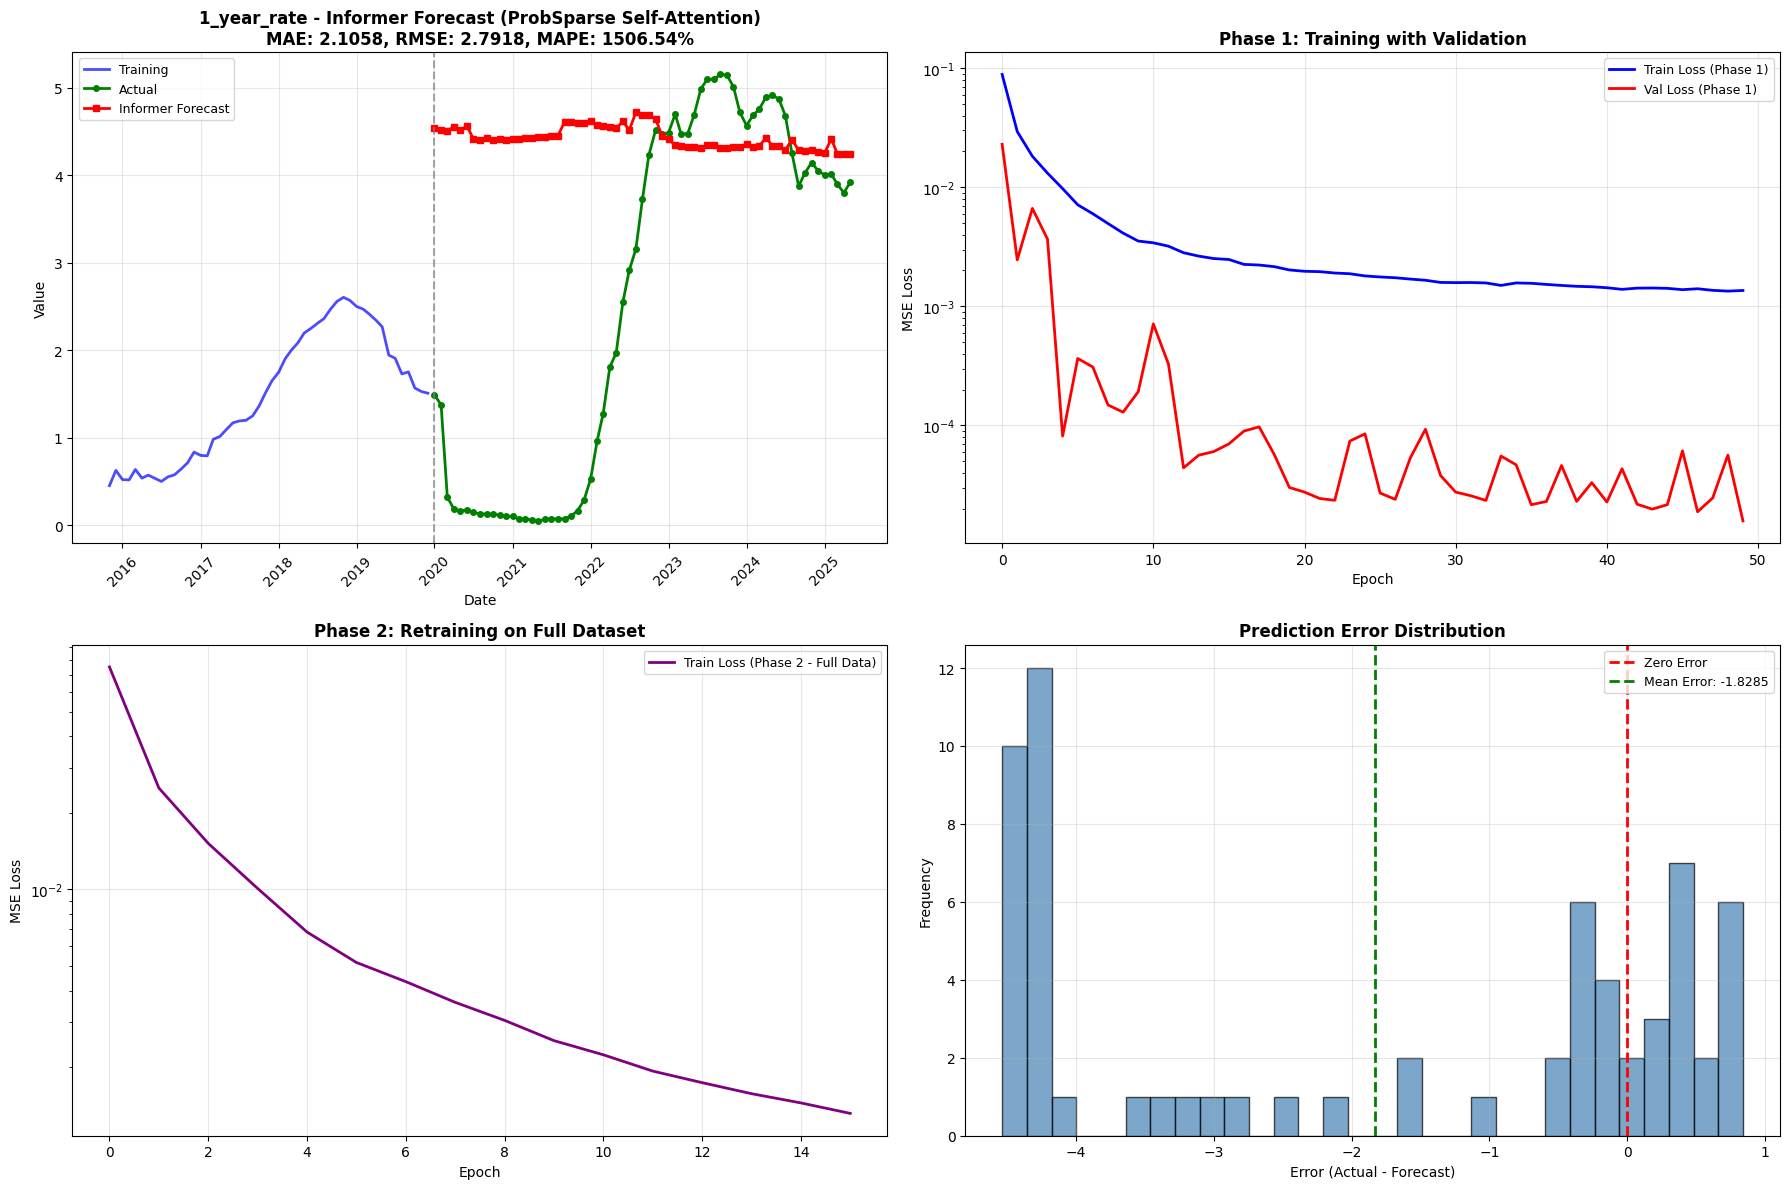


Detailed Statistics for 1_year_rate:
  Mean Error: -1.8285
  Std Error: 2.1096
  Min Error: -4.5351
  Max Error: 0.8389
  Validation split used: 127 samples

FORECASTING WITH INFORMER: 3_months_rate
Data availability check:
  Original train_df length: 635
  Missing values in train: 0 (0.0%)
  Original test_df length: 65
  Missing values in test: 0 (0.0%)
After removing NaNs - Train: 635, Test: 65
Date ranges:
  Train: 1967-02-01 to 2019-12-01
  Test: 2020-01-01 to 2025-05-01

Auto-adjusting Informer parameters...
  Train length: 635, Test length: 65
  Adjusted parameters:
    seq_len: 55
    label_len: 27
    pred_len: 19

Preparing exogenous features for 3_months_rate...
Available exogenous features: 29
Features: ['1_year_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning exogenous features for 3_months_rate...
  NaNs in target before cleaning - Train: 0, Test: 0
  NaNs in target after cleanin

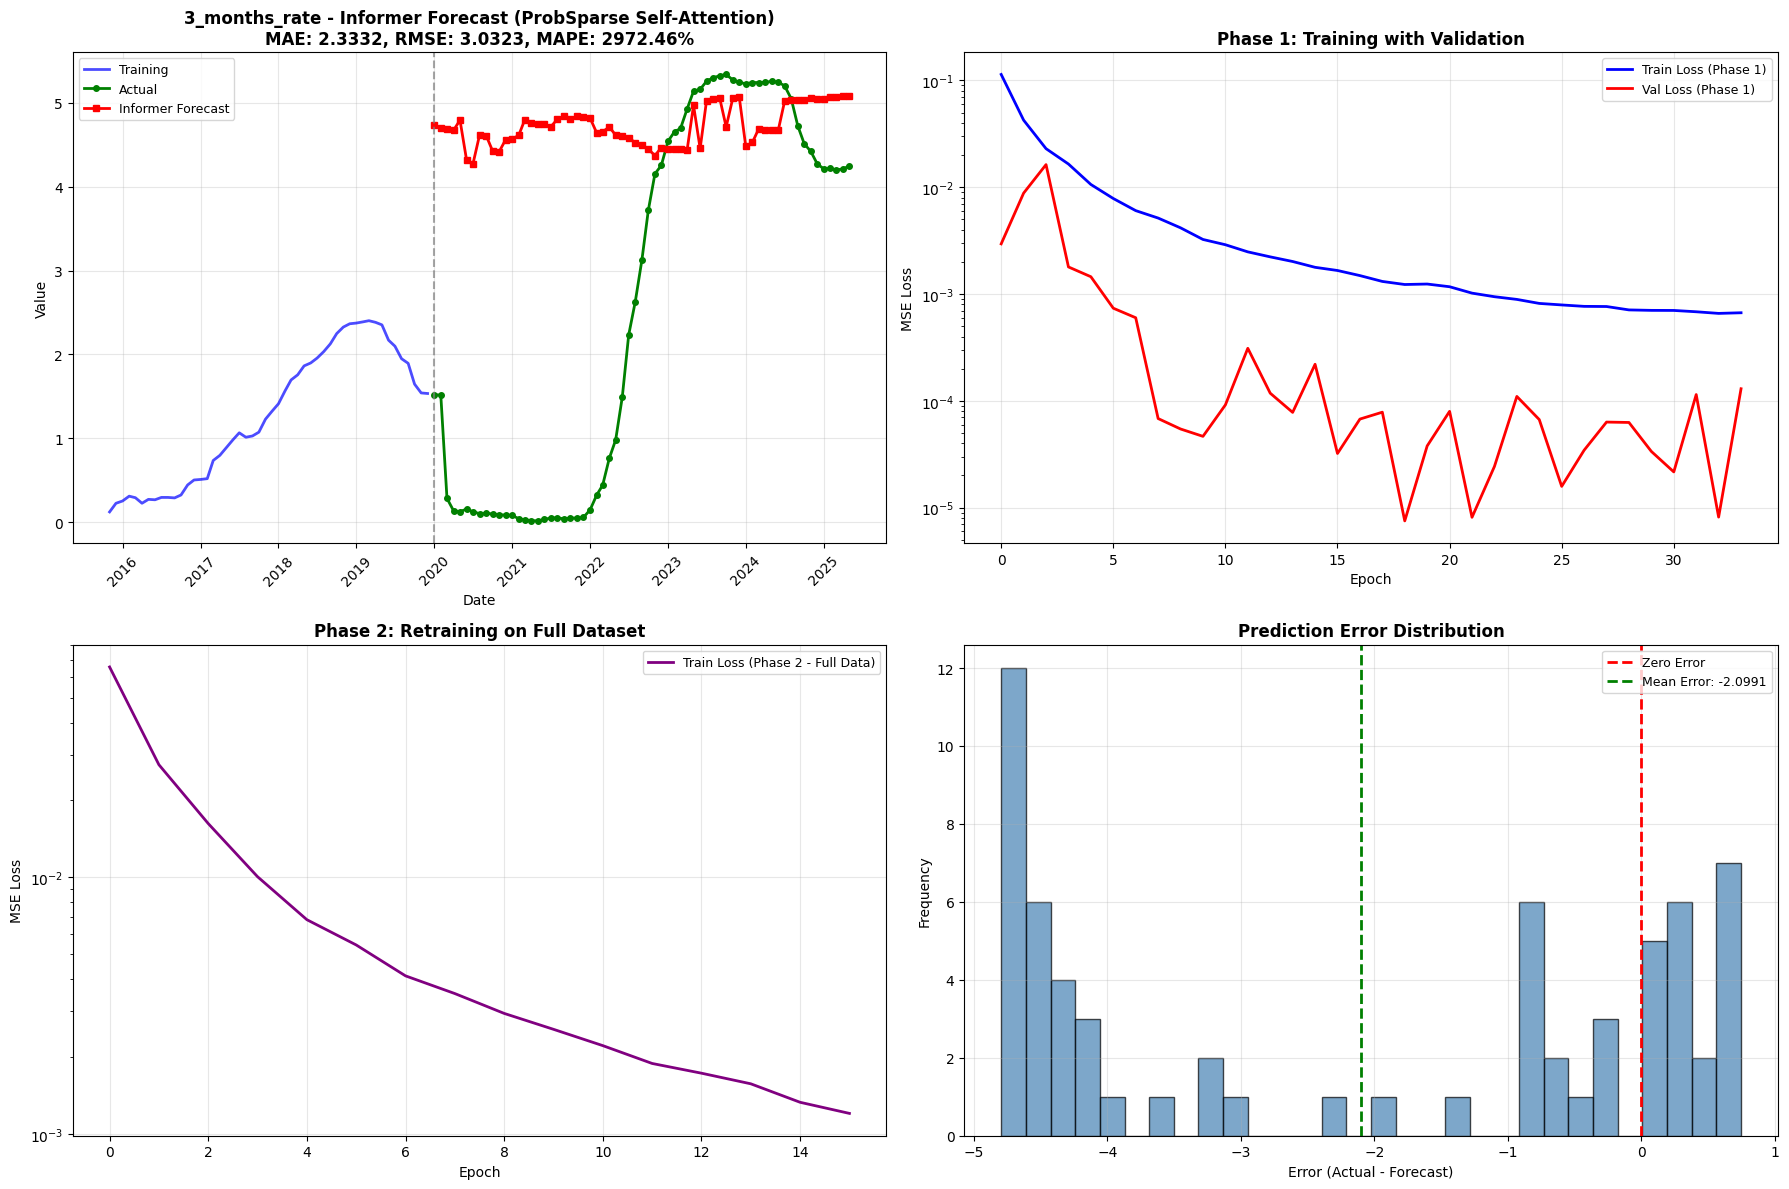


Detailed Statistics for 3_months_rate:
  Mean Error: -2.0991
  Std Error: 2.1883
  Min Error: -4.7944
  Max Error: 0.7468
  Validation split used: 127 samples

FORECASTING WITH INFORMER: 6_months_rate
Data availability check:
  Original train_df length: 635
  Missing values in train: 0 (0.0%)
  Original test_df length: 65
  Missing values in test: 0 (0.0%)
After removing NaNs - Train: 635, Test: 65
Date ranges:
  Train: 1967-02-01 to 2019-12-01
  Test: 2020-01-01 to 2025-05-01

Auto-adjusting Informer parameters...
  Train length: 635, Test length: 65
  Adjusted parameters:
    seq_len: 55
    label_len: 27
    pred_len: 19

Preparing exogenous features for 6_months_rate...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning exogenous features for 6_months_rate...
  NaNs in target before cleaning - Train: 0, Test: 0
  NaNs in target after clean

In [28]:
results, forecasted = run_informer_forecasting(
    train_df, 
    test_df,
    plot_results=True
)

# # Or manually set smaller values
# results, forecasted = run_informer_forecasting(
#     train_df, test_df,
#     seq_len=48,       # 4 years lookback
#     label_len=24,     # 2 years label
#     pred_len=12,      # 1 year forecast
#     auto_adjust=False
# )